<h1>Flight Fare Prediction</h1>
<h3>Rubin Carkaxhia - Big Data Analytics Project Work</h3>

<p>The implementation of this project involves using data-mining techniques to predict the flight price by analyzing a dataset obtained from "Easy My Trip" website and made available on Kaggle.<br>The ML algotithms used in this work are: Random Forest, Linear Regression, GBT, Decision Tree Regressor and Generalized Linear Regressor.
<br>The metrics used to evaluate the models are: RMSE, $R^2$, Mean Squared Error(MSE) and Mean Absolute Error(MAE).</p>

<h3>Imports</h3>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import RFormula, StringIndexer
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor, GeneralizedLinearRegression, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, lit, when,count,isnan, mean
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

<h3>Instantiating a Spark Session</h3>

In [2]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

24/05/06 13:44:45 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
spark

<h3>Reading the data</h3>

In [4]:
data = spark.read.format("csv")\
.option("header", "True")\
.option("inferSchema", "True")\
.option("path","Spark/Data/flight_data.csv").load()

<h1>Data Exploration</h1>

In [4]:
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)
data.show(10)

+---+--------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
|_c0| airline| flight|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|price|
+---+--------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
|  0|SpiceJet|SG-8709|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|    2.17|        1| 5953|
|  1|SpiceJet|SG-8157|      Delhi| Early_Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5953|
|  2| AirAsia| I5-764|      Delhi| Early_Morning| zero|Early_Morning|          Mumbai|Economy|    2.17|        1| 5956|
|  3| Vistara| UK-995|      Delhi|       Morning| zero|    Afternoon|          Mumbai|Economy|    2.25|        1| 5955|
|  4| Vistara| UK-963|      Delhi|       Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5955|
|  5| Vistara| UK-945|      Delhi|      

In [6]:
data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- airline: string (nullable = true)
 |-- flight: string (nullable = true)
 |-- source_city: string (nullable = true)
 |-- departure_time: string (nullable = true)
 |-- stops: string (nullable = true)
 |-- arrival_time: string (nullable = true)
 |-- destination_city: string (nullable = true)
 |-- class: string (nullable = true)
 |-- duration: double (nullable = true)
 |-- days_left: integer (nullable = true)
 |-- price: integer (nullable = true)



The column '<b>_c0</b>' represents the index, while the other 11 columns represent:

       1.  airline:             airline company
       2.  flight:              flight number
       3.  source_city:         city of take off
       4.  departure_time:      departure time
       5.  stops:               number of stops between the source and the destination
       6.  arrival_time:        arrival time
       7.  destination_city:    city where the flight will land
       8.  class:               seat class: economy/business
       9.  duration:            flight duration
       10. days_left:           days left by subtracting the trip date by the booking date
       11. price:               ticket price
      

In [7]:
#print number of rows and columns 
print((data.count(), len(data.columns)))

(300153, 12)


<h1>Data Preprocessing</h1>

<h5>Let's first check if there are any missing values</h5>

In [8]:
data.select([count(when(col(c).isNull(),c)).alias(c) for c in data.columns]).show()

+---+-------+------+-----------+--------------+-----+------------+----------------+-----+--------+---------+-----+
|_c0|airline|flight|source_city|departure_time|stops|arrival_time|destination_city|class|duration|days_left|price|
+---+-------+------+-----------+--------------+-----+------------+----------------+-----+--------+---------+-----+
|  0|      0|     0|          0|             0|    0|           0|               0|    0|       0|        0|    0|
+---+-------+------+-----------+--------------+-----+------------+----------------+-----+--------+---------+-----+



In [9]:
data.describe(['duration', 'days_left','price']).show()

+-------+------------------+------------------+------------------+
|summary|          duration|         days_left|             price|
+-------+------------------+------------------+------------------+
|  count|            300153|            300153|            300153|
|   mean|12.221020812717926|26.004750910369044|20889.660523133203|
| stddev| 7.191997238118976| 13.56100368709348|22697.767366074524|
|    min|              0.83|                 1|              1105|
|    max|             49.83|                49|            123071|
+-------+------------------+------------------+------------------+



<h5>I drop the column 'flight' since it is not useful.</h5>

In [5]:
data = data.drop('flight')
data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- airline: string (nullable = true)
 |-- source_city: string (nullable = true)
 |-- departure_time: string (nullable = true)
 |-- stops: string (nullable = true)
 |-- arrival_time: string (nullable = true)
 |-- destination_city: string (nullable = true)
 |-- class: string (nullable = true)
 |-- duration: double (nullable = true)
 |-- days_left: integer (nullable = true)
 |-- price: integer (nullable = true)



<h1>Exploratory data analysis - EDA</h1>

In [6]:
df_pd = data.toPandas()

<h5>Let's count the number of flights per Airline</h5>

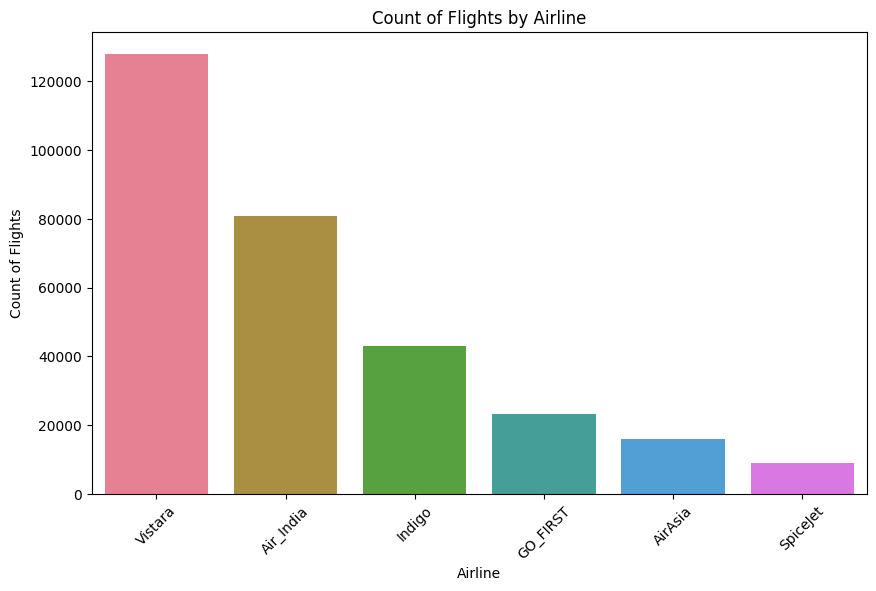

In [12]:
# Calculate count of flights by airline
flight_counts = df_pd['airline'].value_counts()

# Sort the flight counts in descending order
flight_counts = flight_counts.sort_values(ascending=False)

# Plot the data with different colors
plt.figure(figsize=(10, 6))
sns.barplot(x=flight_counts.index, y=flight_counts.values, hue=flight_counts.index, order=flight_counts.index, palette='husl', dodge=False)
plt.xticks(rotation=45)
plt.title("Count of Flights by Airline")
plt.xlabel("Airline")
plt.ylabel("Count of Flights")
plt.show()

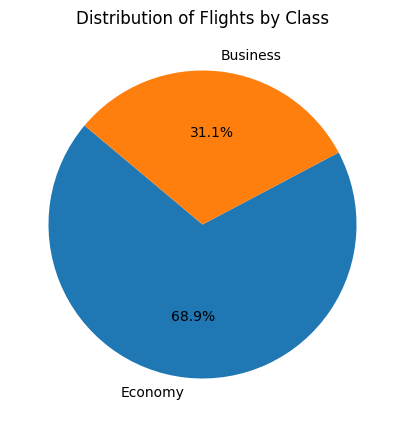

In [13]:
plt.figure(figsize=(15, 5))

# Calculate count of flights by class
class_counts = df_pd['class'].value_counts()

plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Flights by Class")
plt.show()

<h5>We would like to know which features are important for our study, in order to do that we want to be able to check the correlations by looking at the plots</h5>

<h5>Let's see if the ticket price varies between airlines and if it differs across the classes</h5>

Text(0, 0.5, 'Price')

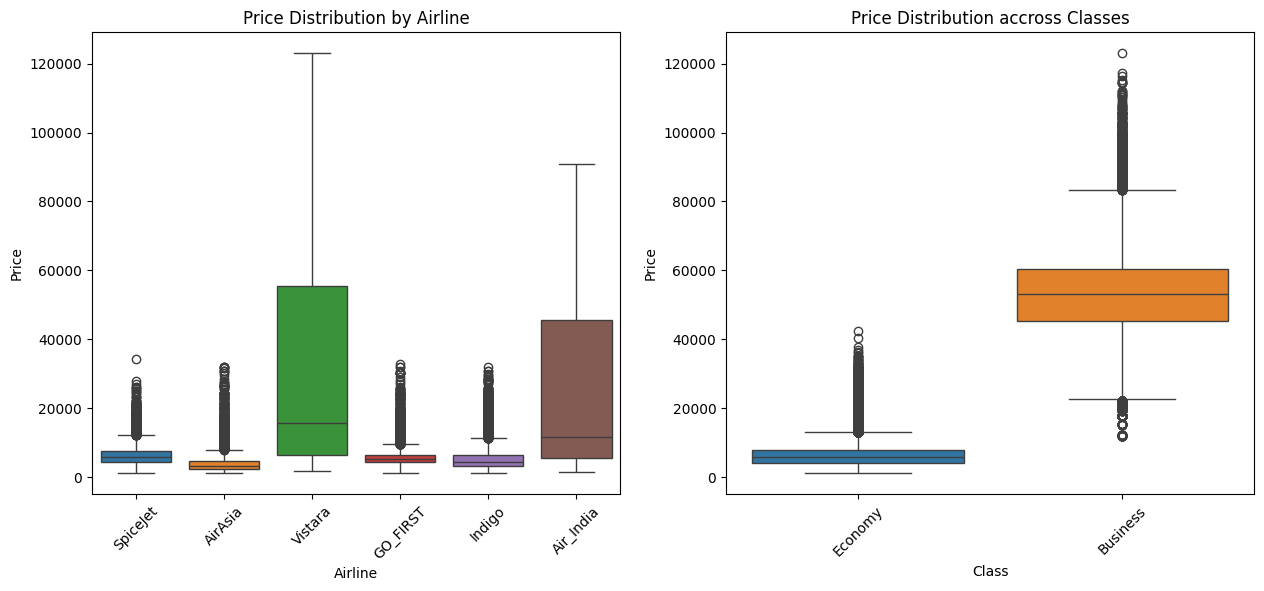

In [14]:
# Set the figure size
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x="airline", y="price", data=df_pd, hue="airline", dodge=False)
plt.xticks(rotation=45)
plt.title("Price Distribution by Airline")
plt.xlabel("Airline")
plt.ylabel("Price")

plt.subplot(1, 2, 2)
sns.boxplot(x="class", y="price", data=df_pd, hue="class", dodge=False)
plt.xticks(rotation=45)
plt.title("Price Distribution accross Classes")
plt.xlabel("Class")
plt.ylabel("Price")

<h5>What we can see from these plots is that Vistara and Air India are the most expensive companies while air asia is the one with the cheapest tickets. On the right plot we can notice that the business class tickets are way more expensive that the economy ones.</h5>

Text(0.5, 1.0, 'Airline prices based on the class and company')

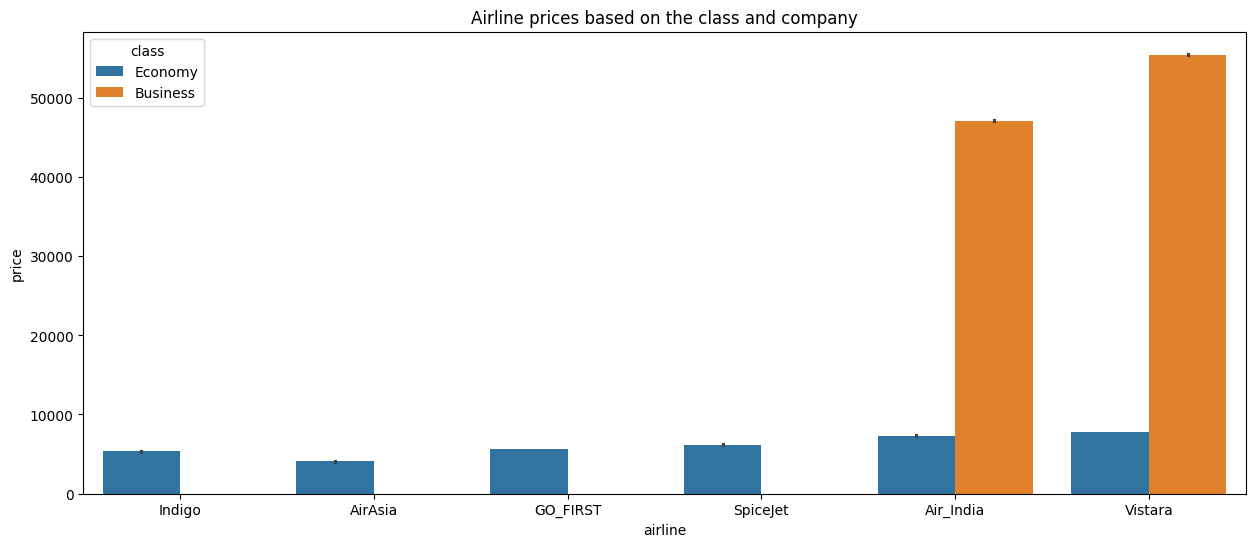

In [15]:
plt.figure(figsize=(15, 6))
sns.barplot(x='airline',y='price',hue="class",data=df_pd.sort_values("price"))
plt.title('Airline prices based on the class and airline')

<h5>Air India and Vistara are the only one companies to have also a business class and we can see that Vistara's business class tickets are more expensive than the ones of Air India.</h5>
<h5>We can conclude this first analysis by saying that the price varies with the airline and also it depends wether it is an economy or business ticket.</h5>
<h5>Now let's see if the price depends also on how many days are left before the departure when the ticket is bought.</h5>

Text(0, 0.5, 'Price')

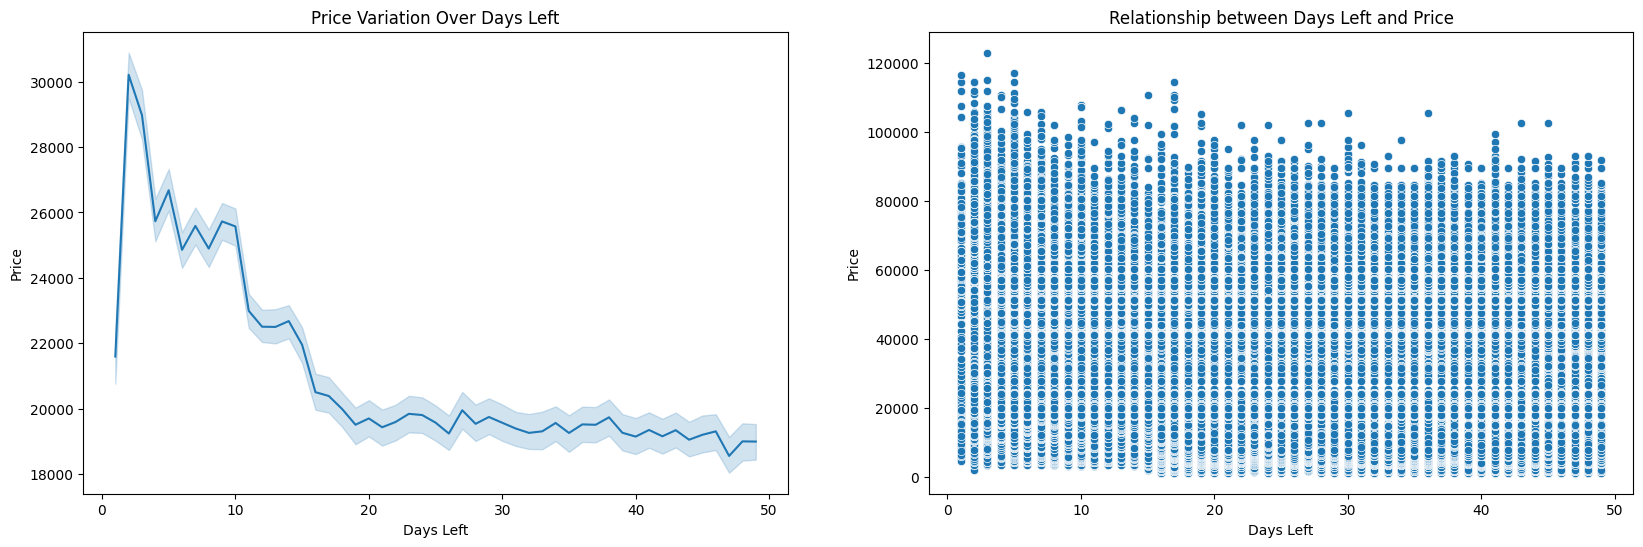

In [16]:
# Price Variation Over Days Left
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
sns.lineplot(x="days_left", y="price", data=df_pd)
plt.title("Price Variation Over Days Left")
plt.xlabel("Days Left")
plt.ylabel("Price")

plt.subplot(1, 2, 2)
sns.scatterplot(x="days_left", y="price", data=df_pd)
plt.title("Relationship between Days Left and Price")
plt.xlabel("Days Left")
plt.ylabel("Price")

<h5>We can clearly see that the price is way higher when the tickets are bought few days before the departure, and that the price decreases with the increasing of the days. Another interesting fact is that the tickets' price drops the day before departure, this may be due to the fact that the airline companies want to fill the remaining seats to ensure the planes remain full.</h5>
<h5>Now let's see if the price depends on the duration.</h5>

Text(0, 0.5, 'Price')

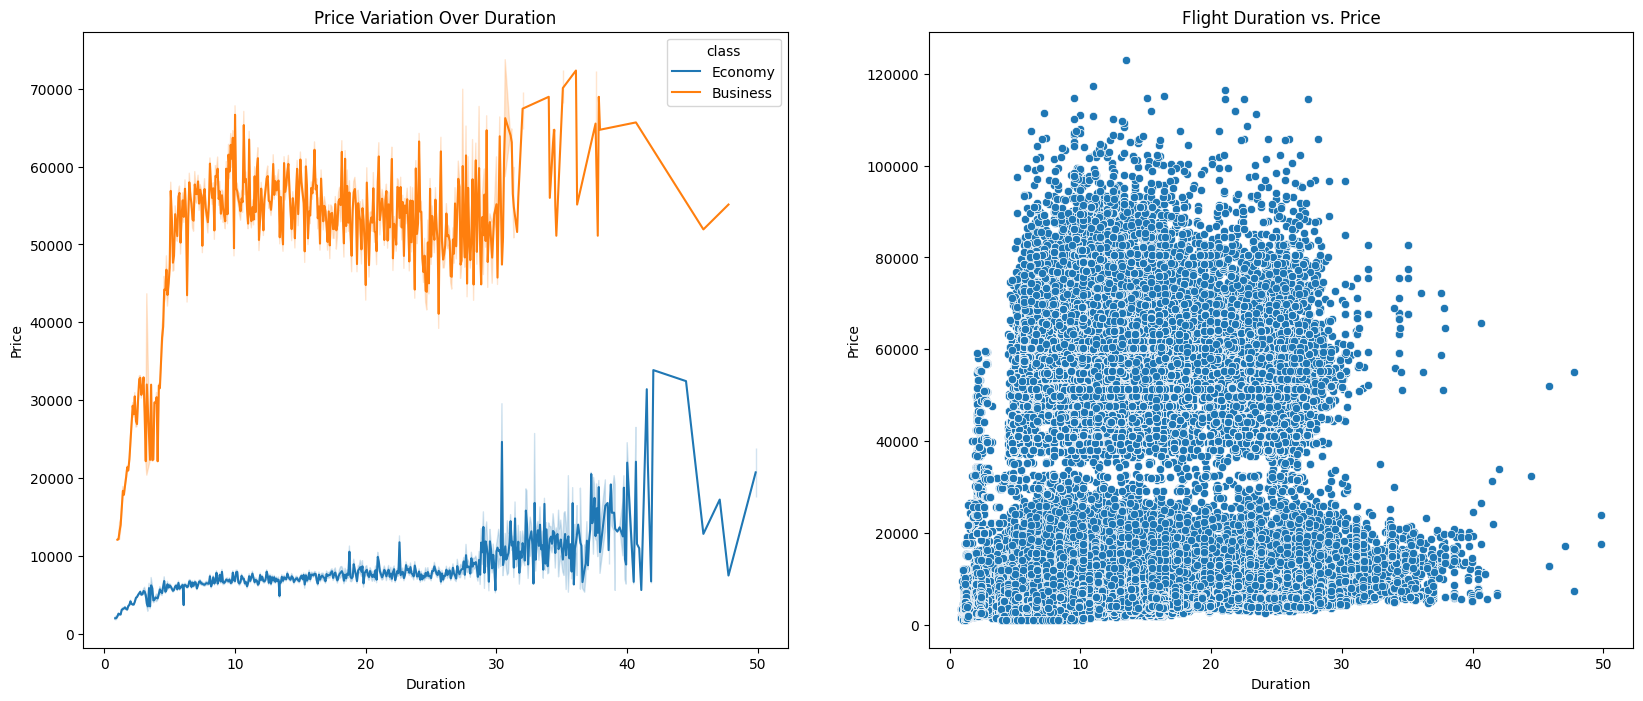

In [17]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.lineplot(x="duration", y="price",hue = "class", data=df_pd)
plt.title("Price Variation Over Duration")
plt.xlabel("Duration")
plt.ylabel("Price")

plt.subplot(1, 2, 2)
sns.scatterplot(x="duration", y="price", data=df_pd)
plt.title("Flight Duration vs. Price")
plt.xlabel("Duration")
plt.ylabel("Price")

<h5>What we can say from the plots is that the price increases with the increase of the flight duration, but after the 20 hours of duration it starts decreasing again.</h5>

<h5>Now, let's see if the number of stops influence the price as well.</h5>

Text(0, 0.5, 'Price')

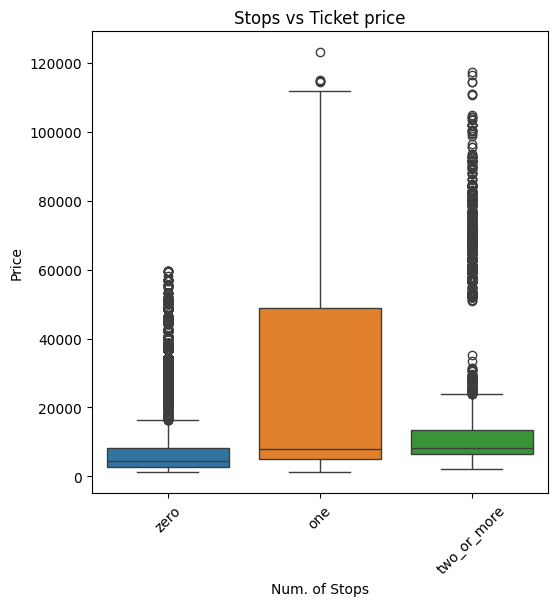

In [19]:
# Set the figure size
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x="stops", y="price", data=df_pd, hue="stops", dodge=False)
plt.xticks(rotation=45)
plt.title("Stops vs Ticket price")
plt.xlabel("Num. of Stops")
plt.ylabel("Price")


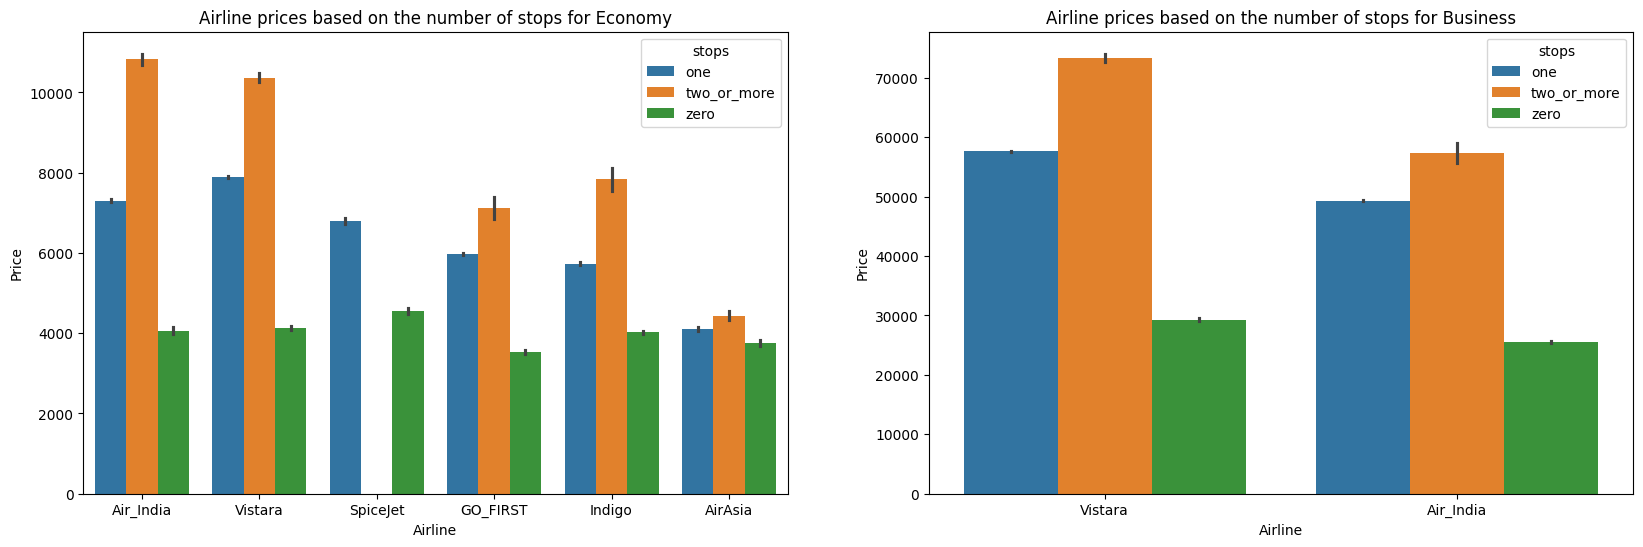

In [20]:
# Filter the DataFrame for Economy class and sort by price in descending order
economy_df = data.filter(data["class"] == "Economy").orderBy(data["price"].desc()).toPandas()

# Filter the DataFrame for Business class and sort by price in descending order
business_df = data.filter(data["class"] == "Business").orderBy(data["price"].desc()).toPandas()

# Set the figure size
plt.figure(figsize=(20, 6))


plt.subplot(1, 2, 1)
# Plot for Economy class
sns.barplot(y="price", x="airline", hue="stops", data=economy_df)
plt.title("Airline prices based on the number of stops for Economy")
plt.xlabel("Airline")
plt.ylabel("Price")

plt.subplot(1, 2, 2)
# Plot for Business class
sns.barplot(y="price", x="airline", hue="stops", data=business_df)
plt.title("Airline prices based on the number of stops for Business")
plt.xlabel("Airline")
plt.ylabel("Price")
plt.show()


<h5>It's easy to notice that the more stops there are the more expensive the tickets are except for AirAsia that tends to have more constant prices.</h5>

<h5>Now it's time to check wether the price depends on the departure and arrival time.</h5>

Text(0, 0.5, 'Price')

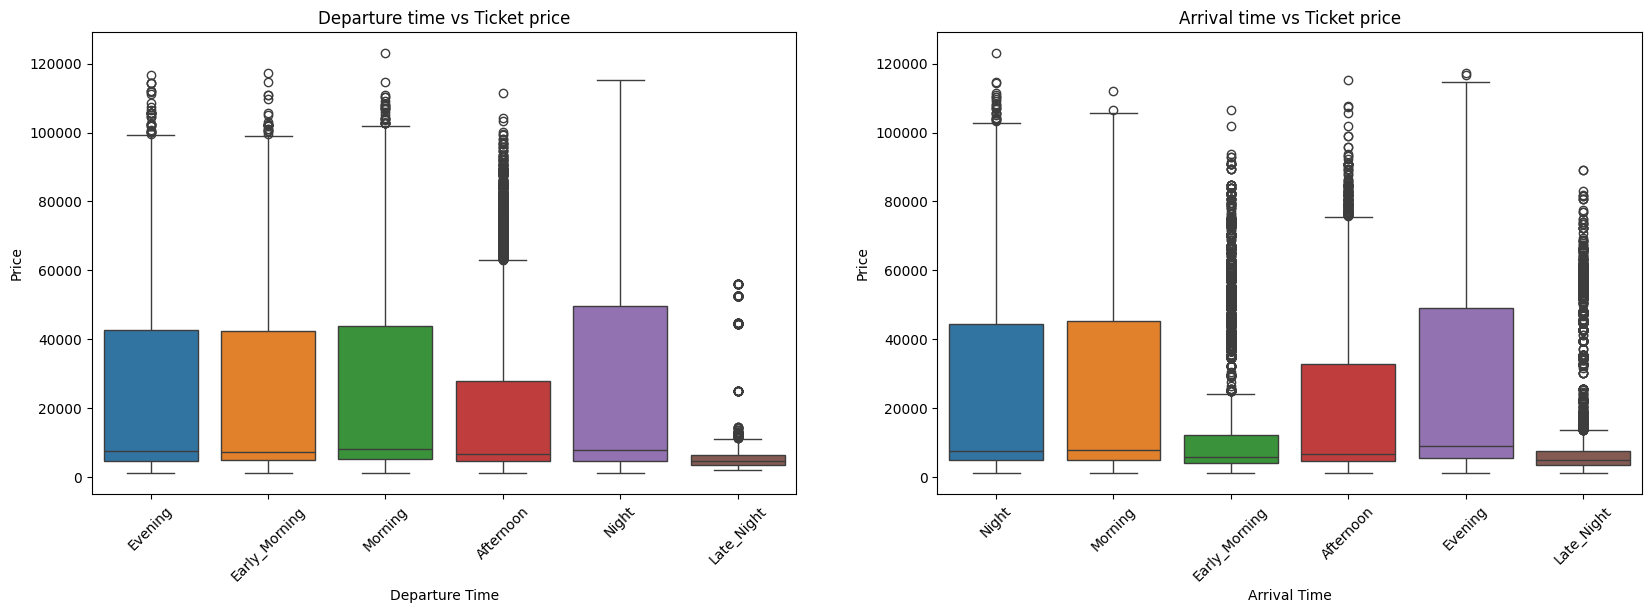

In [21]:
# Set the figure size
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x="departure_time", y="price", data=df_pd, hue="departure_time", dodge=False)
plt.xticks(rotation=45)
plt.title("Departure time vs Ticket price")
plt.xlabel("Departure Time")
plt.ylabel("Price")


plt.subplot(1, 2, 2)
sns.boxplot(x="arrival_time", y="price", data=df_pd, hue="arrival_time", dodge=False)
plt.xticks(rotation=45)
plt.title("Arrival time vs Ticket price")
plt.xlabel("Arrival Time")
plt.ylabel("Price")

<h5>We can clearly see that leaving at night is the cheapest way of traveling, also fliying in the afternoon is convenient. While for the arrival time we can notice that arriving in early morning and late night result having the best prices followed by the arrival in the afternoon.</h5>

<h5>Let's check if the ticket price depends also on the source city.</h5>

Text(0, 0.5, 'Count')

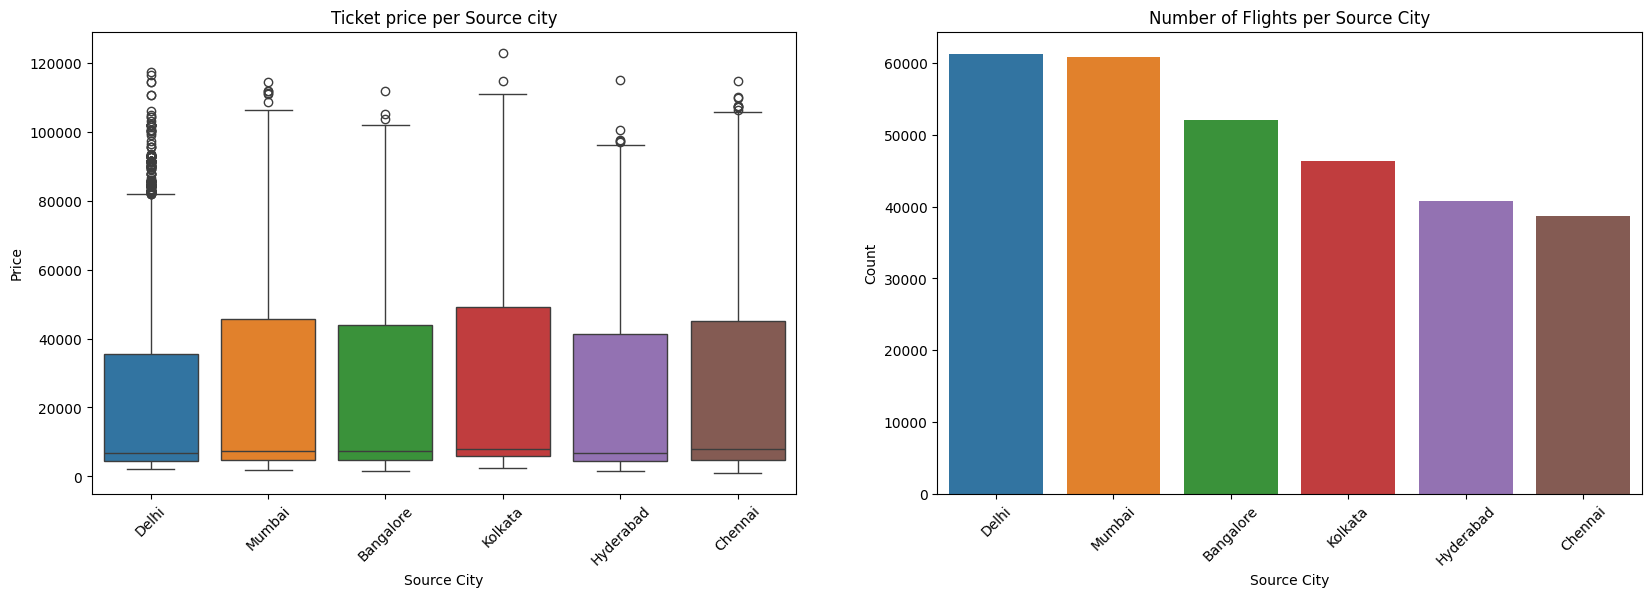

In [22]:
# Set the figure size
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x="source_city", y="price", data=df_pd, hue="source_city", dodge=False)
plt.xticks(rotation=45)
plt.title("Ticket price per Source city")
plt.xlabel("Source City")
plt.ylabel("Price")

# Number of Flights per Source City
plt.subplot(1, 2, 2)
sns.countplot(x="source_city", data=df_pd, hue="source_city")
plt.xticks(rotation=45)
plt.title("Number of Flights per Source City")
plt.xlabel("Source City")
plt.ylabel("Count")

<h5>It seems that flights leaving from Delhi are cheaper compared to the other cities, probably because there are more flights since its the capital city. While the most expensive city to departure from seems to be Kolkata. The other cities have almost the same prices.</h5>

<h5>Finally, let's conclude our EDA by checking if the arrival city influence the price.</h5>

Text(0, 0.5, 'Count')

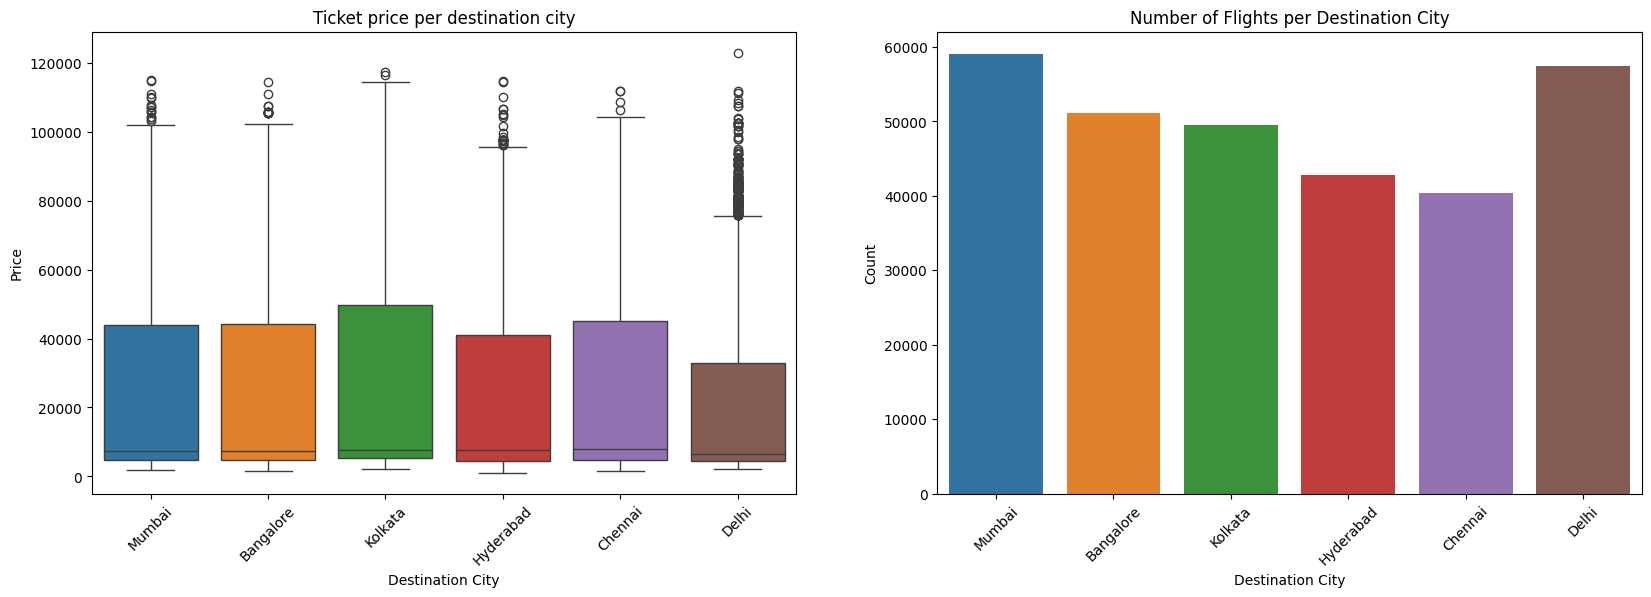

In [23]:
# Set the figure size
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x="destination_city", y="price", data=df_pd, hue="destination_city", dodge=False)
plt.xticks(rotation=45)
plt.title("Ticket price per destination city")
plt.xlabel("Destination City")
plt.ylabel("Price")

# Number of Flights per Source City
plt.subplot(1, 2, 2)
sns.countplot(x="destination_city", data=df_pd, hue="destination_city")
plt.xticks(rotation=45)
plt.title("Number of Flights per Destination City")
plt.xlabel("Destination City")
plt.ylabel("Count")

<h5>Again, arriving in Delhi costs less compared to the other cities, Kolkata is again the city whith the highest ticket price, while the remaining cities have more or less the same prices.</h5>

<h1>Feature Engineering</h1>

<h5>Let's check how many categorical and numerical columns there are.</h5>

In [7]:
cat_count = 0
num_count = 0

for col_name, data_type in data.dtypes:
    if "string" in data_type.lower():
        cat_count += 1
    elif "double" in data_type.lower() or "int" in data_type.lower():
        num_count += 1
        
print(f"There are {cat_count} categorical columns and {num_count} numerical columns")

There are 7 categorical columns and 4 numerical columns


<h5>Since there are 7 categorical columns i have to convert them in numerical ones by using the StringIndexer.</h5>

In [8]:
# Convert string columns to indexed numeric columns
indexer = StringIndexer(inputCols=["airline", "source_city", "departure_time",
                                   "stops", "arrival_time", "destination_city",
                                   "class"],
                        outputCols=["airline_index", "source_city_index",
                                    "departure_time_index", "stops_index",
                                    "arrival_time_index", "destination_city_index",
                                    "class_index"])

df_indexed = indexer.fit(data).transform(data)
columns_to_drop = ["airline", "source_city", "departure_time", "stops", "arrival_time", "destination_city", "class"]
df_indexed = df_indexed.drop(*columns_to_drop)

<h5>Let's check the result.</h5>

In [26]:
df_indexed.show(5)

+---+--------+---------+-----+-------------+-----------------+--------------------+-----------+------------------+----------------------+-----------+
|_c0|duration|days_left|price|airline_index|source_city_index|departure_time_index|stops_index|arrival_time_index|destination_city_index|class_index|
+---+--------+---------+-----+-------------+-----------------+--------------------+-----------+------------------+----------------------+-----------+
|  0|    2.17|        1| 5953|          5.0|              0.0|                 2.0|        1.0|               0.0|                   0.0|        0.0|
|  1|    2.33|        1| 5953|          5.0|              0.0|                 1.0|        1.0|               2.0|                   0.0|        0.0|
|  2|    2.17|        1| 5956|          4.0|              0.0|                 1.0|        1.0|               4.0|                   0.0|        0.0|
|  3|    2.25|        1| 5955|          0.0|              0.0|                 0.0|        1.0|     

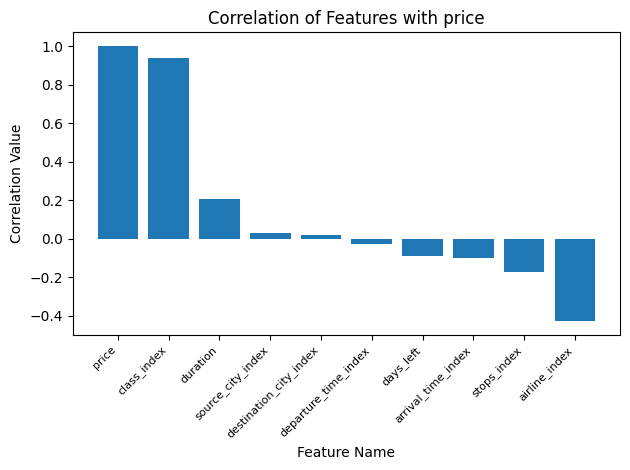

In [27]:
target_column = "price"  

# Combine all columns except the one containing the indexes into a single vector 
feature_cols = [col for col in df_indexed.columns if col != '_c0']
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data_assembled = vector_assembler.transform(df_indexed)

correlation_matrix = Correlation.corr(data_assembled, "features").head()

# Extract the correlation values for the target column
correlation_values = correlation_matrix[0].toArray()[:, feature_cols.index(target_column)]

correlation_dict = dict(zip(feature_cols, correlation_values))

# Extract the feature names from the correlation dictionary
feature_names = correlation_dict.keys()

# Sort the features and correlation values together by correlation value
sorted_pairs = sorted(correlation_dict.items(), key=lambda x: x[1], reverse=True)
feature_names, correlation_values = zip(*sorted_pairs)

plt.bar(feature_names, correlation_values)
plt.xlabel("Feature Name")
plt.ylabel("Correlation Value")
plt.title(f"Correlation of Features with {target_column}")
plt.xticks(rotation=45, ha='right', fontsize=8) 
plt.tight_layout()
plt.show()

<h5>I am gonna keep all the features since, as we previously saw in the EDA, they all might influence the price.</h5>

In [9]:
rfdata = RFormula(formula="price ~ .")
rf_fit_data = rfdata.fit(df_indexed)
rf_transfd_data = rf_fit_data.transform(df_indexed)

In [10]:
train_data, test_data = rf_transfd_data.randomSplit([0.7, 0.3], seed = 42)

<h1>Machine Learning Model Building & Evaluation </h1>

<h3>Linear Regressor</h3>

In [8]:
lr = LinearRegression(featuresCol='features', labelCol='price')

param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

evaluator = RegressionEvaluator(metricName='rmse', labelCol='price')

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)

cv_model = crossval.fit(train_data)
best_lr_model = cv_model.bestModel

# Print the best hyperparameters
print("Best regParam: ", best_lr_model.getRegParam())
print("Best elasticNetParam: ", best_lr_model.getElasticNetParam())

24/03/18 03:50:26 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/03/18 03:50:28 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Best regParam:  0.01
Best elasticNetParam:  0.5


In [9]:
# Make predictions on the test data using the best model
best_lr_predictions = best_lr_model.transform(test_data)

best_lr_predictions.select("price","prediction").show()

metrics=['rmse', 'r2', 'mse', 'mae']
best_lr_results = {}

for metric in metrics:
        evaluator = RegressionEvaluator(labelCol='price', metricName=metric)
        metric_result = evaluator.evaluate(best_lr_predictions)
        best_lr_results[metric] = metric_result

for metric_name, met_result in best_lr_results.items():
    print(f"Best Linear Regressor - {metric_name.capitalize()}: {met_result}")

+-----+------------------+
|price|        prediction|
+-----+------------------+
| 5956| 4385.221353975472|
| 6060| 8238.117731188693|
| 5954| 5865.999406904295|
| 5954| 5583.726328112354|
| 5955| 6431.805677680559|
| 5955| 6304.305386117948|
| 5955| 6839.179782190101|
| 5949| 8989.763001128675|
| 5954|10383.613236737427|
| 5955|  9764.71195633942|
| 6165|6867.9827888756145|
|10260|   4986.3218032252|
|10470| 7121.081861000648|
|10575| 8133.583673070794|
|12150|11588.901403826272|
|12150|  11706.5723280426|
|12150|13490.367229075031|
|12123| 8084.244396383025|
|12150|12711.468179762573|
|12150|13098.880760268145|
+-----+------------------+
only showing top 20 rows



Best Linear Regressor - Rmse: 7333.030412834703
Best Linear Regressor - R2: 0.8951457936418872
Best Linear Regressor - Mse: 53773335.0355587
Best Linear Regressor - Mae: 4541.224323870971


<h3>Random Forest</h3>

In [10]:
rf = RandomForestRegressor(featuresCol='features', labelCol='price')

paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 20, 50]) \
             .addGrid(rf.maxDepth, [5, 10, 15]) \
             .addGrid(rf.maxBins, [32, 64, 128]) \
             .addGrid(rf.minInstancesPerNode, [1, 2, 5]) \
             .build())

evaluator = RegressionEvaluator(metricName='rmse', labelCol='price')

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)

cv_model = crossval.fit(train_data)
best_rf_model = cv_model.bestModel

24/03/18 03:55:31 WARN BlockManager: Asked to remove block broadcast_185, which does not exist
24/03/18 03:55:31 WARN BlockManager: Asked to remove block broadcast_185_piece0, which does not exist


In [11]:
# Print the best hyperparameters
print("Random Forest numTrees:", best_rf_model.getNumTrees)
print("Random Forest maxDepth:", best_rf_model.getMaxDepth())
print("Random Forest maxBins:", best_rf_model.getMaxBins())
print("Random Forest minInstancesPerNode", best_rf_model.getMinInstancesPerNode())

Random Forest numTrees: 20
Random Forest maxDepth: 5
Random Forest maxBins: 32
Random Forest minInstancesPerNode 1


In [12]:
# Make predictions on the test data using the best model
best_rf_predictions = best_rf_model.transform(test_data)

best_rf_predictions.select("price","prediction").show()

metrics=['rmse', 'r2', 'mse', 'mae']
best_rf_results = {}

for metric in metrics:
        evaluator = RegressionEvaluator(labelCol='price', metricName=metric)
        metric_result = evaluator.evaluate(best_rf_predictions)
        best_rf_results[metric] = metric_result

for metric_name, met_result in best_rf_results.items():
    print(f"Best Random Forest Regressor - {metric_name.capitalize()}: {met_result}")

+-----+------------------+
|price|        prediction|
+-----+------------------+
| 5956| 6485.127976711754|
| 6060| 6126.918745401598|
| 5954| 6394.180432064953|
| 5954| 7031.590114289303|
| 5955| 6541.069346236789|
| 5955| 7031.590114289303|
| 5955| 6912.220093083891|
| 5949|  9719.92452974185|
| 5954|10194.803572200566|
| 5955| 9023.066739015809|
| 6165| 6912.220093083891|
|10260| 6755.061990594106|
|10470| 6537.527590588288|
|10575| 10020.56330213998|
|12150|12073.995758203133|
|12150| 12106.70540361157|
|12150| 12106.70540361157|
|12123|10360.708264572711|
|12150|12071.048490714544|
|12150|12071.048490714544|
+-----+------------------+
only showing top 20 rows



Best Random Forest Regressor - Rmse: 5354.111785453119
Best Random Forest Regressor - R2: 0.944102323784666
Best Random Forest Regressor - Mse: 28666513.011127986
Best Random Forest Regressor - Mae: 3149.2976375226567


<h3>Gradient Boosted Trees</h3>

In [ ]:
gbt = GBTRegressor(featuresCol='features', labelCol='price')

param_grid = ParamGridBuilder() \
             .addGrid(gbt.maxDepth, [5, 10, 15]) \
             .build()


evaluator = RegressionEvaluator(metricName='rmse', labelCol='price')

crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=3)

cv_model = crossval.fit(train_data)
best_gbt_model = cv_model.bestModel

In [27]:
print("GBT maxDepth:", best_gbt_model.getMaxDepth())

GBT maxDepth: 10


In [28]:
# Make predictions on the test data using the best model
best_gbt_predictions = best_gbt_model.transform(test_data)

best_gbt_predictions.select("price","prediction").show()

metrics=['rmse', 'r2', 'mse', 'mae']
best_gbt_results = {}

for metric in metrics:
        evaluator = RegressionEvaluator(labelCol='price', metricName=metric)
        metric_result = evaluator.evaluate(best_gbt_predictions)
        best_gbt_results[metric] = metric_result

for metric_name, met_result in best_gbt_results.items():
    print(f"Best GBT Regressor - {metric_name.capitalize()}: {met_result}")

+-----+------------------+
|price|        prediction|
+-----+------------------+
| 5956| 5132.846998433664|
| 6060| 7280.500757200118|
| 5954| 5996.672916947912|
| 5954| 6598.970660529838|
| 5955| 6872.994193026768|
| 5955| 6722.791102030439|
| 5955| 6886.171024173891|
| 5949| 6412.034609531629|
| 5954|11651.474072586921|
| 5955|15765.652996588533|
| 6165| 6886.171024173891|
|10260| 6101.062705898072|
|10470| 6496.917518040181|
|10575|14525.904044112054|
|12150|14874.966392177412|
|12150|15089.084220722028|
|12150|14384.316070694593|
|12123| 9633.692659972066|
|12150|16588.785507401844|
|12150|16410.221706060227|
+-----+------------------+
only showing top 20 rows



Best GBT Regressor - Rmse: 3541.6336983373712
Best GBT Regressor - R2: 0.9755417056355172
Best GBT Regressor - Mse: 12543169.253198847
Best GBT Regressor - Mae: 1952.554585910067


<h3>Generalized Linear Regressor</h3>

In [11]:
glr = GeneralizedLinearRegression(featuresCol='features', labelCol='price')

param_grid = ParamGridBuilder() \
             .addGrid(glr.regParam, [0.1, 0.01]) \
             .addGrid(glr.maxIter, [10, 20, 30]) \
             .build()

evaluator = RegressionEvaluator(metricName='rmse', labelCol='price')

crossval = CrossValidator(estimator=glr,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)

cv_model = crossval.fit(train_data)
best_glr_model = cv_model.bestModel

24/05/06 13:46:28 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/06 13:46:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [12]:
# Print the best hyperparameters
print("Best Generalized LR regParam: ", best_glr_model.getRegParam())
print("Best Generalized LR maxIter: ", best_glr_model.getMaxIter())

Best Generalized LR regParam:  0.01
Best Generalized LR maxIter:  10


In [25]:
# Make predictions on the test data using the best model
best_glr_predictions = best_glr_model.transform(test_data)

best_glr_predictions.select("price","prediction").show()

metrics=['rmse', 'r2', 'mse', 'mae']
best_glr_results = {}

for metric in metrics:
        evaluator = RegressionEvaluator(labelCol='price', metricName=metric)
        metric_result = evaluator.evaluate(best_glr_predictions)
        best_glr_results[metric] = metric_result

for metric_name, met_result in best_glr_results.items():
    print(f"Best Generalized Linear Regressor - {metric_name.capitalize()}: {met_result}")

+-----+------------------+
|price|        prediction|
+-----+------------------+
| 5956| 4385.167393559295|
| 6060| 8237.988815118486|
| 5954| 5865.967588650624|
| 5954| 5583.669034683276|
| 5955| 6431.723901510337|
| 5955|6304.2096953808505|
| 5955| 6839.129010408764|
| 5949| 8989.824873775277|
| 5954| 10383.70771139235|
| 5955|  9764.66269773572|
| 6165| 6867.932887384279|
|10260| 4986.409683781579|
|10470| 7121.053663552299|
|10575| 8133.558358622136|
|12150|11588.802168937002|
|12150| 11706.45062303181|
|12150|13490.343499793764|
|12123| 8084.340132935712|
|12150|12711.481470634244|
|12150|13098.891436257645|
+-----+------------------+
only showing top 20 rows



Best Generalized Linear Regressor - Rmse: 7333.028354667957
Best Generalized Linear Regressor - R2: 0.895145852500885
Best Generalized Linear Regressor - Mse: 53773304.85036424
Best Generalized Linear Regressor - Mae: 4541.220653782031


<h3>Decision Tree Regressor</h3>

In [ ]:
dt = DecisionTreeRegressor(featuresCol='features', labelCol='price')

param_grid = ParamGridBuilder() \
             .addGrid(dt.maxDepth, [5, 10, 15]) \
             .addGrid(dt.maxBins, [32, 64, 128]) \
             .addGrid(dt.minInstancesPerNode, [1, 2, 5]) \
             .build()

evaluator = RegressionEvaluator(metricName='rmse', labelCol='price')

crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)

cv_model = crossval.fit(train_data)
best_dt_model = cv_model.bestModel

In [20]:
# Print the best hyperparameters
print("DT maxDepth:", best_dt_model.getMaxDepth())
print("DT maxBins:", best_dt_model.getMaxBins())
print("DT minInstancesPerNode", best_dt_model.getMinInstancesPerNode())

DT maxDepth: 15
DT maxBins: 128
DT minInstancesPerNode 5


In [21]:
# Make predictions on the test data using the best model
best_dt_predictions = best_dt_model.transform(test_data)

best_dt_predictions.select("price","prediction").show()

metrics=['rmse', 'r2', 'mse', 'mae']
best_dt_results = {}

for metric in metrics:
        evaluator = RegressionEvaluator(labelCol='price', metricName=metric)
        metric_result = evaluator.evaluate(best_dt_predictions)
        best_dt_results[metric] = metric_result

for metric_name, met_result in best_dt_results.items():
    print(f"Best Decision Tree Regressor - {metric_name.capitalize()}: {met_result}")

24/03/18 04:14:36 WARN DAGScheduler: Broadcasting large task binary with size 1245.5 KiB


+-----+------------------+
|price|        prediction|
+-----+------------------+
| 5956|            5952.0|
| 6060|            7492.8|
| 5954|            5952.0|
| 5954|            5952.0|
| 5955| 6615.833333333333|
| 5955|            5952.0|
| 5955| 6615.833333333333|
| 5949|            8224.8|
| 5954|            6165.2|
| 5955|           10098.5|
| 6165| 6615.833333333333|
|10260|            6178.4|
|10470|            6178.4|
|10575|13894.444444444445|
|12150|           17804.5|
|12150|           17804.5|
|12150|           17804.5|
|12123| 9866.545454545454|
|12150|20803.714285714286|
|12150|           13935.0|
+-----+------------------+
only showing top 20 rows



24/03/18 04:14:39 WARN DAGScheduler: Broadcasting large task binary with size 1253.0 KiB
24/03/18 04:14:41 WARN DAGScheduler: Broadcasting large task binary with size 1253.0 KiB
24/03/18 04:14:43 WARN DAGScheduler: Broadcasting large task binary with size 1253.0 KiB
24/03/18 04:14:45 WARN DAGScheduler: Broadcasting large task binary with size 1253.0 KiB


Best Decision Tree Regressor - Rmse: 3529.5340997357007
Best Decision Tree Regressor - R2: 0.9757085382636083
Best Decision Tree Regressor - Mse: 12457610.961197102
Best Decision Tree Regressor - Mae: 1757.6026269155702


<h3>Scatter plot of the results obtained with the different models</h3>
<h4>Plotting the 2 best models</h4>

24/03/18 05:07:14 WARN DAGScheduler: Broadcasting large task binary with size 1245.0 KiB


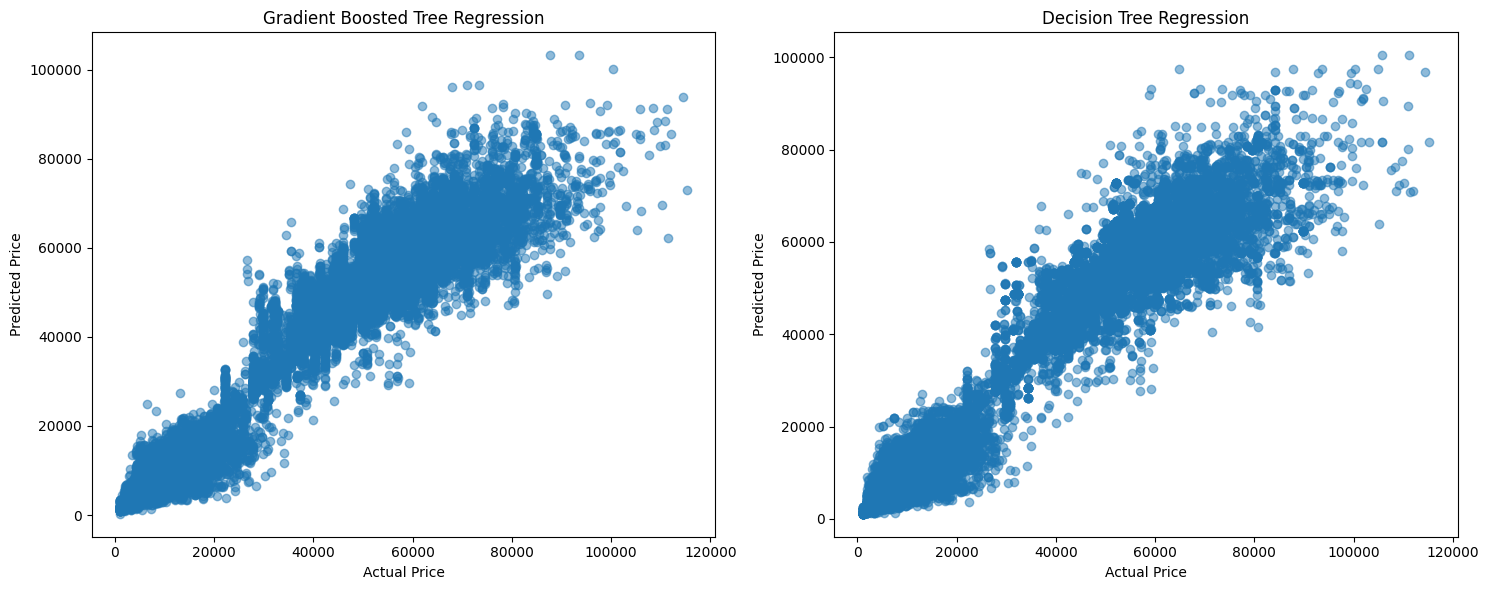

In [34]:
plt.figure(figsize=(15, 6))

# Collect data for plotting

plot_gbt = best_gbt_predictions.select("price", "prediction").toPandas()


plot_dt = best_dt_predictions.select("price", "prediction").toPandas()


plt.subplot(1, 2, 1)
plt.scatter(plot_gbt['price'], plot_gbt['prediction'], alpha=0.5)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Gradient Boosted Tree Regression')

plt.subplot(1, 2, 2)
plt.scatter(plot_dt['price'], plot_dt['prediction'], alpha=0.5)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Decision Tree Regression')

plt.tight_layout()
plt.show()

<h5>Results Overview</h5>

In [32]:
metrics_data = {
    'Model': ['Linear Regression', 'Random Forest Regression', 'Gradient Boosted Tree Regression', 'Generalized Linear Regression', 'Decision Tree Regressor'],
    'RMSE': [best_lr_results['rmse'], best_rf_results['rmse'], best_gbt_results['rmse'], best_glr_results['rmse'], best_dt_results['rmse']],
    'R2': [best_lr_results['r2'], best_rf_results['r2'], best_gbt_results['r2'], best_glr_results['r2'], best_dt_results['r2']],
    'MSE': [best_lr_results['mse'], best_rf_results['mse'], best_gbt_results['mse'], best_glr_results['mse'], best_dt_results['mse']],
    'MAE': [best_lr_results['mae'], best_rf_results['mae'], best_gbt_results['mae'], best_glr_results['mae'], best_dt_results['mae']]   
}

metrics_df = pd.DataFrame(metrics_data)

metrics_df

,Model,RMSE,R2,MSE,MAE
0,Linear Regression,7333.030413,0.895146,5.377334e+07,4541.224324
1,Random Forest Regression,5354.111785,0.944102,2.866651e+07,3149.297638
2,Gradient Boosted Tree Regression,3541.633698,0.975542,1.254317e+07,1952.554586
3,Generalized Linear Regression,7333.028355,0.895146,5.377330e+07,4541.220654
4,Decision Tree Regressor,3529.534100,0.975709,1.245761e+07,1757.602627


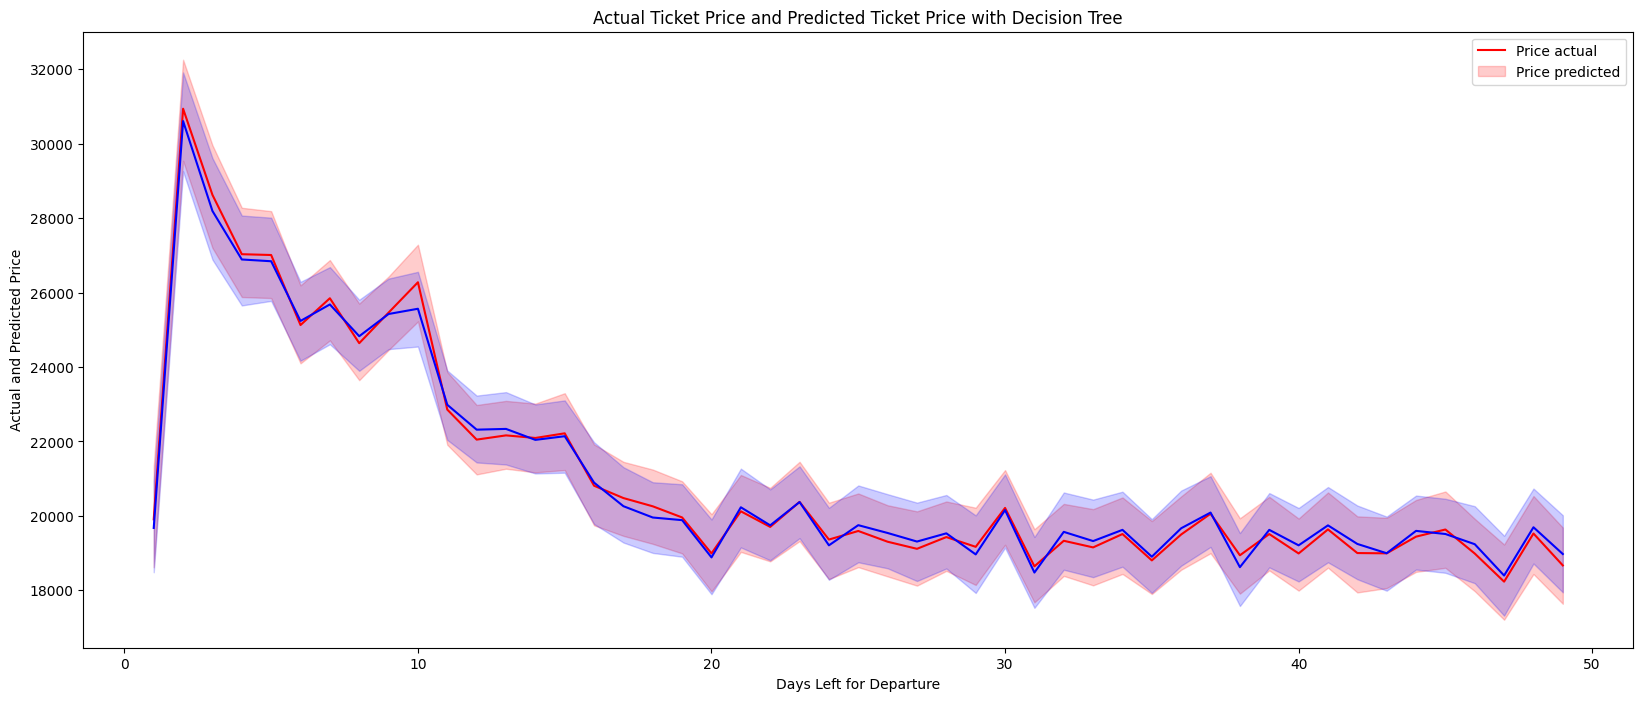

In [43]:
best_dt_predictions = best_dt_predictions.toPandas()
plt.figure(figsize=(20,8))
sns.lineplot(data=best_dt_predictions, x='days_left', y='price', color='red')
sns.lineplot(data=best_dt_predictions, x='days_left', y='prediction', color='blue')
plt.title('Actual Ticket Price and Predicted Ticket Price with Decision Tree')
plt.legend(labels=['Price actual','Price predicted'])
plt.xlabel('Days Left for Departure')
plt.ylabel('Actual and Predicted Price')
plt.show()

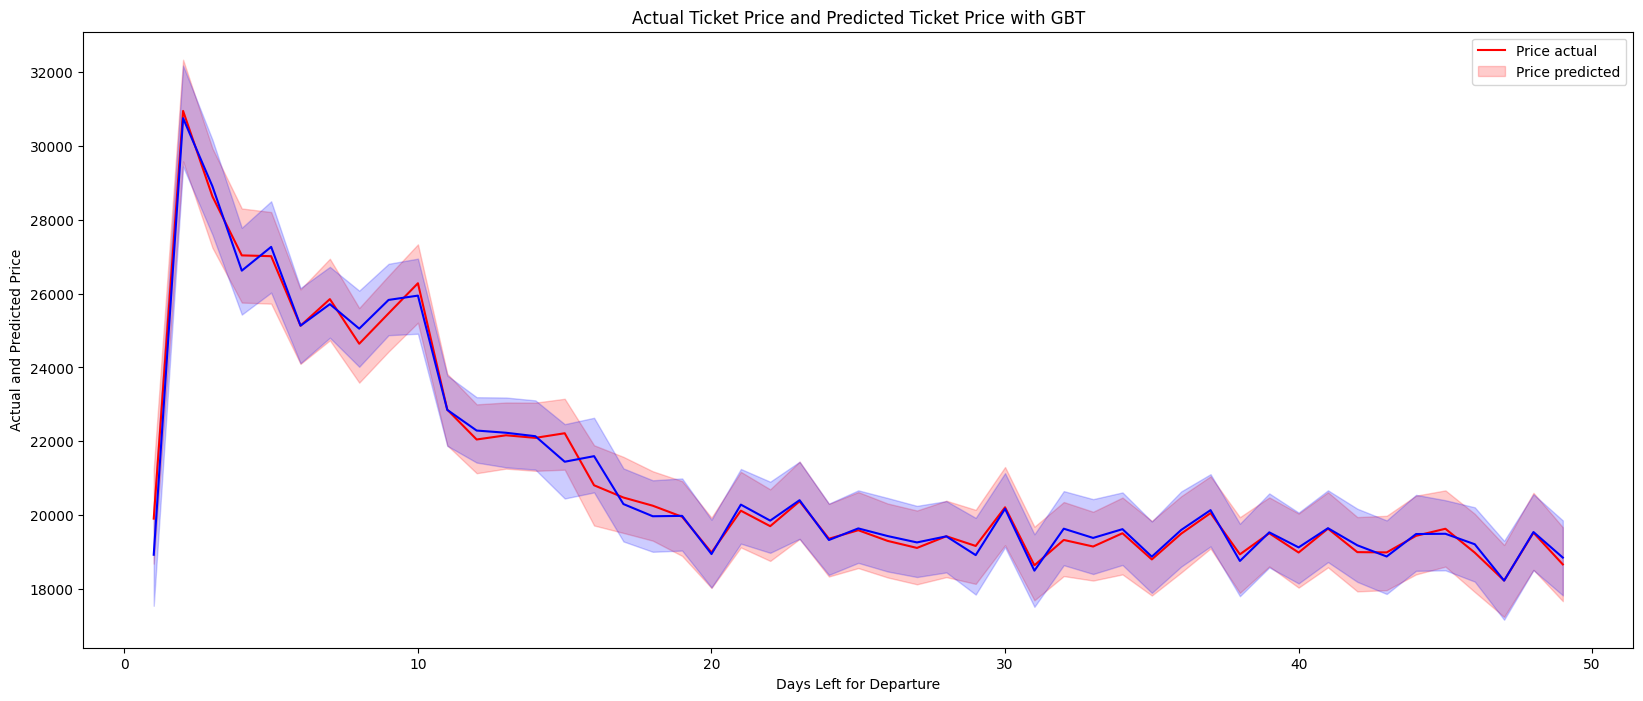

In [42]:
best_gbt_predictions = best_gbt_predictions.toPandas()
plt.figure(figsize=(20,8))
sns.lineplot(data=best_gbt_predictions, x='days_left', y='price', color='red')
sns.lineplot(data=best_gbt_predictions, x='days_left', y='prediction', color='blue')
plt.title('Actual Ticket Price and Predicted Ticket Price with GBT')
plt.legend(labels=['Price actual','Price predicted'])
plt.xlabel('Days Left for Departure')
plt.ylabel('Actual and Predicted Price')
plt.show()